In [1]:
import fastai
from fastai.vision import *

In [2]:
path = Path('.')

In [3]:
train = path/'train_dehaze/'
test =  path/'leaderboard_test_data_dehaze/'
holdout = path/'leaderboard_holdout_data_dehaze/'
sample_sub = path/'SampleSubmission.csv'
labels = path/'traininglabels.csv'

In [4]:
test_names = [f for f in test.iterdir()]
holdout_names = [f for f in holdout.iterdir()]

In [5]:
df = pd.read_csv(labels)
df_sample = pd.read_csv(sample_sub)

In [6]:
df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [7]:
# df = df[df.score>0.85]

In [8]:
N = len(df); N

15244

In [9]:
def get_data(size=128, bs=64, pct=0.2, seed=2019, n_sample=len(df)):
    src = (ImageItemList.from_df(df.sample(n_sample), path, folder=train)
           .random_split_by_pct(pct, seed=seed)
           .label_from_df('has_oilpalm')
           .add_test(test_names+holdout_names))
    return (src.transform(get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.), size=size)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

In [10]:
#This was working perfectly some minutes ago!
from sklearn.metrics import roc_auc_score
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1])) # use as metric

def get_learner(data, arch=models.resnet50, mixup=True):
    learn = create_cnn(data, 
                       arch, 
                       metrics=[accuracy])
    if mixup: learn.mixup()
    return learn.to_fp16()

In [12]:
data = get_data(256, 64)

In [13]:
learn = get_learner(data)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02


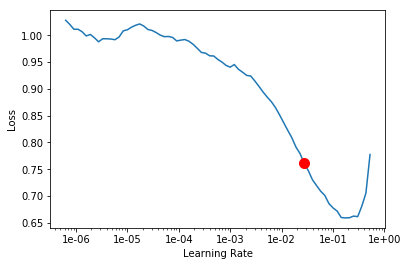

In [13]:
learn.lr_find(); learn.recorder.plot()

In [14]:
lr = 2e-2

256

In [15]:
learn.fit_one_cycle(12, lr)
learn.save('256')

epoch,train_loss,valid_loss,accuracy
1,0.067727,0.036171,0.988845
2,0.067438,0.091669,0.976378
3,0.086505,0.041544,0.986877
4,0.084729,0.041613,0.989173
5,0.063256,0.042189,0.989501
6,0.057366,0.046549,0.983596
7,0.051379,0.055330,0.982940
8,0.042854,0.037906,0.988189
9,0.037200,0.025700,0.989173
10,0.029459,0.024444,0.990486


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06


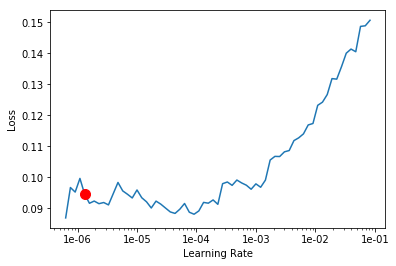

In [17]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [18]:
learn.fit_one_cycle(6, slice(1e-6,1e-4))
learn.save('256u')

epoch,train_loss,valid_loss,accuracy
1,0.097671,0.034911,0.991470
2,0.095352,0.034597,0.992126
3,0.099524,0.034091,0.991798
4,0.095822,0.032261,0.991470
5,0.098263,0.032854,0.991798
6,0.093986,0.032164,0.991798


In [31]:
learn.to_fp16()
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

In [48]:
learn = get_learner(get_data(256, 64, 0.01))
learn.load('256u')
learn.model.float()
p,t = learn.TTA(ds_type=DatasetType.Test)

In [49]:
p = to_np(p); p.shape

(6534, 2)

In [50]:
preds = p[:,1]

# X-validation

In [11]:
# sample = 500
%time
f = open("log.txt","w+")
folds = 5
preds = 0
for i in range(folds):
    f.write(f'---Fold {i}---\n')
    data = get_data(256, 64, seed=i)
    learn = get_learner(data)
    learn.freeze()
    learn.fit_one_cycle(12, slice(2e-2))
    learn.save(f'256-{i}')
    learn.unfreeze()
    learn.fit_one_cycle(20, slice(1e-6,1e-4))
    learn.save(f'256u-{i}')
    p,t = learn.get_preds()
    f.write(f'  AUC score after fold {i} :{auc_score(p,t)}\n')
    
    #TTA shit
    learn = get_learner(get_data(256, 48))
    learn.load(f'256u-{i}')
    learn.model.float()
    p,t = learn.TTA(ds_type=DatasetType.Test)
    
    preds += to_np(p[:,1])/folds
   
f.close()

In [12]:
np.save('preds_5fold_R50',preds)

## Sub file

In [13]:
ids = np.array([f.name for f in test_names]+[f.name for f in holdout_names])

In [14]:
ids.shape

(6534,)

In [15]:
sub = pd.DataFrame(np.stack([ids, preds], axis=1), columns=df_sample.columns)

In [16]:
sub.to_csv('sub_resnet50x5_haze_TTA.csv', index=False)